In [144]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [234]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
dd = load_diabetes()
print(dd['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [235]:
# Save the input and target variables
# dd.keys()
data = dd['data']
targets = dd['target']

In [236]:
# Normalise the target data (this will make clearer training curves)
targets = (targets-targets.mean(axis=0))/targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [482]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.15, random_state=1111)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(375, 10)
(67, 10)
(375,)
(67,)


#### Train a feedforward neural network model

In [483]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model
unregularised_model = get_model()

In [484]:
# Print the model summary
unregularised_model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_303 (Dense)            (None, 128)               1408      
_________________________________________________________________
dense_304 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_305 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_306 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_307 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_308 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_309 (Dense)            (None, 1)               

In [485]:
# Compile the model
import tensorflow as tf
opt = tf.keras.optimizers.Adam()
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
ba = tf.keras.metrics.BinaryAccuracy()
# model.compile(optimizer = opt, loss=mse, metrics=[mae])
unregularised_model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

In [486]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback, EarlyStopping

early_stopping = EarlyStopping(monitor='val_mae', patience=3, min_delta=0.01)
# Train the model, with some of the data reserved for validation
unreg_history = unregularised_model.fit(X_train, y_train, epochs=50,
                    validation_split=0.25, batch_size=64, verbose=False,
                   callbacks=[early_stopping])


In [487]:
# Evaluate the model on the test set
unregularised_model.evaluate(X_test, y_test)

67/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.36476383903133336, 0.47856942]

#### Plot the learning curves

In [488]:
import matplotlib.pyplot as plt
%matplotlib inline

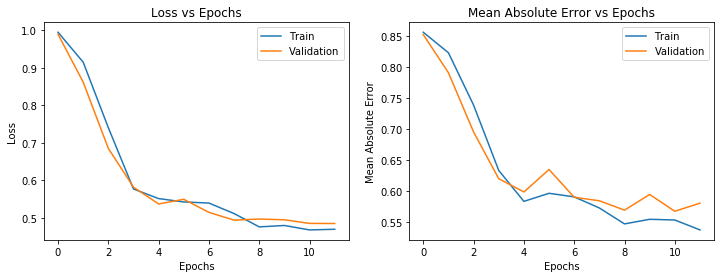

In [489]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# frame = pd.DataFrame(history.history)
frame = pd.DataFrame(unreg_history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mae'], label="Train")
ax.plot(epochs, frame['val_mae'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error vs Epochs")
ax.legend()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [490]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [491]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [492]:
# Re-build the model with weight decay and dropout layers
regularised_model = get_regularised_model(1e-5,0.3)


In [493]:
# Compile the model
import tensorflow as tf
opt = tf.keras.optimizers.Adam()
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
ba = tf.keras.metrics.BinaryAccuracy()
regularised_model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

In [494]:
# Train the model, with some of the data reserved for validation
early_stopping = EarlyStopping(monitor='val_mae', patience=5, min_delta=0.01)
# Train the model, with some of the data reserved for validation
reg_history = regularised_model.fit(X_train, y_train, epochs=100,
                    validation_split=0.25, batch_size=64, verbose=False,
                   callbacks=[early_stopping])

In [495]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test)

67/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.35799997422232555, 0.48306724]

#### Plot the learning curves

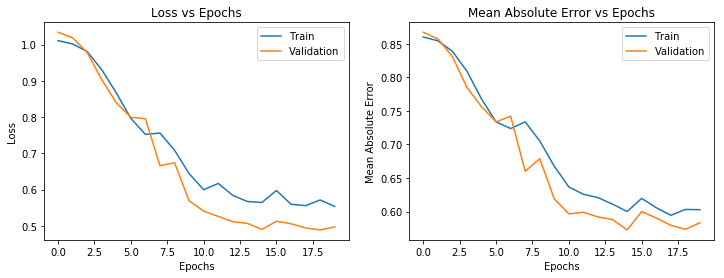

In [496]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

frame = pd.DataFrame(reg_history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mae'], label="Train")
ax.plot(epochs, frame['val_mae'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error vs Epochs")
ax.legend()

In [498]:
# Load the dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
data = diabetes_dataset['data']
targets = diabetes_dataset['target']
targets = (targets - targets.mean(axis=0)) / (targets.std())

In [499]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.15, random_state=1111)

In [519]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
def batch_normalization_model(rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        BatchNormalization(), 
        Dropout(rate),
        Dense(128, activation="relu"),
        BatchNormalization(), 
        Dropout(rate),
        Dense(128, activation="relu"), #BatchNormalization(), 
        BatchNormalization(momentum=0.95, epsilon=0.005,axis = -1,
        beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dense(1)
    ])
    return model

In [526]:
model = batch_normalization_model(0.5)

In [527]:
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_329 (Dense)            (None, 128)               1408      
_________________________________________________________________
batch_normalization_86 (Batc (None, 128)               512       
_________________________________________________________________
dropout_146 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_330 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_87 (Batc (None, 128)               512       
_________________________________________________________________
dropout_147 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_331 (Dense)            (None, 128)             

In [528]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
ba = tf.keras.metrics.BinaryAccuracy()
#model.compile(optimizer = opt, loss=mse, metrics=[mae])

model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

In [529]:
# Train the model, with some of the data reserved for validation
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
RLROnP = ReduceLROnPlateau() #monitor="mae", factor=0.2, verbose=1)
history = model.fit(X_train, y_train, epochs=150,
                    validation_split=0.2, batch_size=64, verbose=False, callbacks=[RLROnP])


In [530]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test)

67/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3174115650689424, 0.45599762]

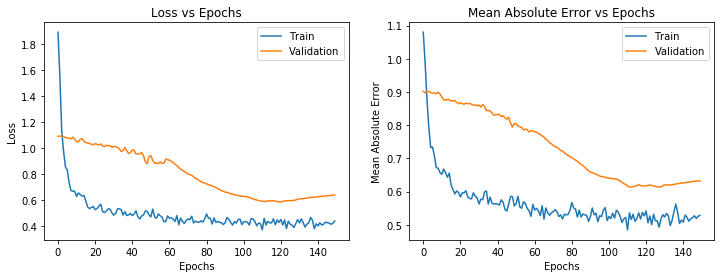

In [531]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

frame = pd.DataFrame(history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mae'], label="Train")
ax.plot(epochs, frame['val_mae'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error vs Epochs")
ax.legend()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [364]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    
    def on_train_end(self, logs=None):
        print("Finished training!")


In [366]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [367]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#### Train the model with the callback

In [368]:
# Train the model, with some of the data reserved for validation

model.fit(X_train, y_train, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [370]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback, EarlyStopping

class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")

    def on_test_end(self, logs=None):
        print("Finished testing!")


In [371]:
# Evaluate the model

model.evaluate(X_test, y_test, verbose=False, callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


[0.8641235378053453, 0.76378435]

In [372]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction....")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")

    def on_predict_end(self, logs=None):
        print("Finished prediction!")


In [373]:
# Make predictions with the model
model.predict(X_test, verbose=False, callbacks=[PredictionCallback()])


Starting prediction....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!


array([[ 0.0319311 ],
       [ 0.01529899],
       [-0.02420317],
       [-0.06053931],
       [-0.00845981],
       [ 0.00906308],
       [-0.08625468],
       [ 0.02221292],
       [ 0.01844934],
       [-0.07505403],
       [-0.07794401],
       [-0.07320543],
       [-0.07536938],
       [ 0.02402539],
       [-0.00564076],
       [-0.07305727],
       [-0.00185815],
       [-0.08425479],
       [-0.08272601],
       [-0.07504199],
       [ 0.00649013],
       [-0.07355647],
       [-0.00054911],
       [-0.07050561],
       [-0.05370948],
       [-0.01217586],
       [-0.08924083],
       [-0.03941473],
       [-0.08416481],
       [-0.08474924],
       [-0.01316042],
       [-0.07649169],
       [-0.07188275],
       [-0.03564112],
       [-0.084849  ],
       [-0.07992008],
       [ 0.00126604],
       [ 0.02894838],
       [-0.08855861],
       [-0.08192685],
       [-0.07155276],
       [-0.08582263],
       [-0.08668312],
       [-0.06425618],
       [ 0.00029996]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [ ]:
# Re-train the unregularised model



In [ ]:
# Evaluate the model on the test set



In [ ]:
# Re-train the regularised model



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

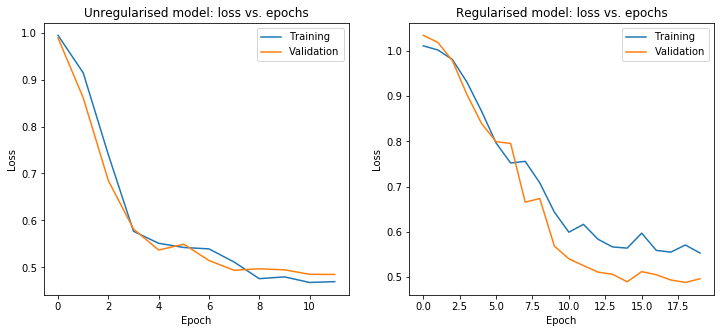

In [497]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()